In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.stats as stats
import pymannkendall as mk
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [2]:
## The script is used to reproduce: 
##         Fig. 1. Time series of the boreal summer QRA event counts from 1950 to 2024.

# Define homepath
homepath = "/pscratch/sd/x/xueke/"

# Define periods
startyear = 1950
endyear = 2024
startyear_overlap = 1950
endyear_overlap = 2016

yyrange = np.arange(startyear_overlap, endyear_overlap+1, 1) # Overlapping period 1950-2016
ERA5_yyrange = np.arange(startyear, endyear+1, 1)            # Full time interval: 1950-2024
GISTEMP_yyrange = np.arange(1880,2017,1)
HadCRUT_yyrange = np.arange(1850,2017,1)
HadCRUT_krig_yyrange = np.arange(1850,2017,1)

# Plot settings
labelsize = 14
size = 16
colors = plt.cm.jet(np.linspace(0,1,5))
col_freq  = colors[0]
col_GISTEMP = colors[2]
col_HadCRUT = colors[3]
col_HadCRUT_krig = colors[4]

## El Niño years based on the Oceanic Niño Index (ONI)

In [3]:
# El Niño years (ONI >= O.5)
el_nino_years = [1952, 1954, 1959, 1964, 1966, 1969, 
                 1970, 1977, 1978, 1980,  1987, 1988, 
                 1995, 2003, 2005, 2007,  2015, 2019]
str_el_nino_years = [1958, 1973, 1983, 1992, 1998, 2010, 2016, 2024]
all_el_nino_years = sorted(el_nino_years + str_el_nino_years)

## ERA5-based QRA count series

In [4]:
# Read csv file
QRA_ERA5 = homepath + "data/QRA_freq_"+str(startyear)+"-"+str(endyear)+".csv"
df = pd.read_csv(QRA_ERA5)
qra_yr = df['Year']
freq = df['Frequency']

# Select data with overlapping period 1950-2016
freq2 = np.array(freq)[ERA5_yyrange <= yyrange[-1]]

# Calculate mean and standard deviation of the QRA count series
freq2_mean = np.nanmean(freq2)
freq2_std = np.nanstd(freq2)

## Observation-based QRA fingerprint series from Mann et al. (2017)

In [5]:
# Read netCDF file
QRA_GISTEMP_fp = homepath + "data/GISTEMP_latband_2017_1880-2016_jja_lat-25n-75n_QRAindex.nc"
QRA_HadCRUT_fp = homepath + "data/HadCRUT_latband_2017_1850-2016_jja_lat-25n-75_QRAindex.nc"
QRA_HadCRUT_krig_fp = homepath + "data/HadCRUT_krig_latband_2017_1850-2016_jja_lat-25n-75n_QRAindex.nc"

QRA_GISTEMP = xr.open_mfdataset(QRA_GISTEMP_fp, decode_times=False).tas
QRA_HadCRUT = xr.open_mfdataset(QRA_HadCRUT_fp, decode_times=False).tas
QRA_HadCRUT_krig = xr.open_mfdataset(QRA_HadCRUT_krig_fp, decode_times=False).tas

QRA_GISTEMP_1d = QRA_GISTEMP.values.flatten()
QRA_HadCRUT_1d = QRA_HadCRUT.values.flatten()
QRA_HadCRUT_krig_1d = QRA_HadCRUT_krig.values.flatten()

# Select data with overlapping period 1950-2016
QRA_GISTEMP2 = QRA_GISTEMP_1d[GISTEMP_yyrange >= yyrange[0]]
QRA_HadCRUT2 = QRA_HadCRUT_1d[HadCRUT_yyrange >= yyrange[0]]
QRA_HadCRUT_krig2 = QRA_HadCRUT_krig_1d[HadCRUT_krig_yyrange >= yyrange[0]]

# Center and normalize the QRA fingerprint series
QRA_GISTEMP2_centered = QRA_GISTEMP2 - np.nanmean(QRA_GISTEMP2)
QRA_GISTEMP2_norm = QRA_GISTEMP2_centered * (freq2_std / np.nanstd(QRA_GISTEMP2_centered)) + freq2_mean

QRA_HadCRUT2_centered = QRA_HadCRUT2 - np.nanmean(QRA_HadCRUT2)
QRA_HadCRUT2_norm = QRA_HadCRUT2_centered * (freq2_std / np.nanstd(QRA_HadCRUT2_centered)) + freq2_mean

QRA_HadCRUT_krig2_centered = QRA_HadCRUT_krig2 - np.nanmean(QRA_HadCRUT_krig2)
QRA_HadCRUT_krig2_norm = QRA_HadCRUT_krig2_centered * (freq2_std / np.nanstd(QRA_HadCRUT_krig2_centered)) + freq2_mean

## Trend calculation and significance test using linear least-squares regression & Mann-Kendall 

In [6]:
############# ERA5-based QRA count series ############# 
### Linear least squares regression (LSR)
# Full time interval: 1950-2024
slope_freq_2024,intercept_freq_2024,rVal_freq_2024,p_freq_2024,stderr_freq_2024 = stats.linregress(ERA5_yyrange, freq, alternative='greater') # alternative='two-sided' 
trend_freq_2024 = slope_freq_2024 * ERA5_yyrange + intercept_freq_2024

# Overlapping period 1950-2016
slope_freq,intercept_freq,rVal_freq,p_freq,stderr_freq = stats.linregress(yyrange, freq2, alternative='greater') # alternative='two-sided'
trend_freq = slope_freq * yyrange + intercept_freq

### M-K test
p_freq_2024_mk = mk.original_test(freq).p                   # 1950 - 2024
slope_freq_2024_mk = mk.original_test(freq).slope           # 1950 - 2024
intercept_freq_2024_mk = mk.original_test(freq).intercept   # 1950 - 2024

p_freq_mk = mk.original_test(freq2).p                       # 1950 - 2016
slope_freq_mk = mk.original_test(freq2).slope               # 1950 - 2016
intercept_freq_mk = mk.original_test(freq2).intercept       # 1950 - 2016

print("**************** ERA5-based QRA count series ****************")
print("                 slope  p-value  stderr")
print("1950-2016 (LSR): ", round(slope_freq,3), round(p_freq,3), round(stderr_freq,3)) 
print("1950-2024 (LSR): ", round(slope_freq_2024, 3), round(p_freq_2024,3), round(stderr_freq_2024,3))    
print("1950-2016 (M-K): ", round(slope_freq_mk,3), round(p_freq_mk/2,3)) 
print("1950-2024 (M-K): ", round(slope_freq_2024_mk, 3), round(p_freq_2024_mk/2,3))    
print()

############# Observation-based QRA fingerprint series ############# 
### Linear least squares regression (LSR)
# Overlapping period 1950-2016
slope_GISTEMP_norm,intercept_GISTEMP_norm,rVal_GISTEMP_norm,p_GISTEMP_norm,stderr_GISTEMP_norm = stats.linregress(yyrange, QRA_GISTEMP2_norm, alternative='greater') # alternative='two-sided'
trend_GISTEMP_norm = slope_GISTEMP_norm * yyrange + intercept_GISTEMP_norm
slope_HadCRUT_norm,intercept_HadCRUT_norm,rVal_HadCRUT_norm,p_HadCRUT_norm,stderr_HadCRUT_norm = stats.linregress(yyrange, QRA_HadCRUT2_norm, alternative='greater') # alternative='two-sided'
trend_HadCRUT_norm = slope_HadCRUT_norm * yyrange + intercept_HadCRUT_norm
slope_HadCRUT_krig_norm,intercept_HadCRUT_krig_norm,rVal_HadCRUT_krig_norm,p_HadCRUT_krig_norm,stderr_HadCRUT_krig_norm = stats.linregress(yyrange, QRA_HadCRUT_krig2_norm, alternative='greater') # alternative='two-sided' 
trend_HadCRUT_krig_norm = slope_HadCRUT_krig_norm * yyrange + intercept_HadCRUT_krig_norm

### M-K test
p_GISTEMP_norm_mk = mk.original_test(QRA_GISTEMP2_norm).p
slope_GISTEMP_norm_mk = mk.original_test(QRA_GISTEMP2_norm).slope
intercept_GISTEMP_norm_mk = mk.original_test(QRA_GISTEMP2_norm).intercept
p_HadCRUT_norm_mk = mk.original_test(QRA_HadCRUT2_norm).p
slope_HadCRUT_norm_mk = mk.original_test(QRA_HadCRUT2_norm).slope
intercept_HadCRUT_norm_mk = mk.original_test(QRA_HadCRUT2_norm).intercept
p_HadCRUT_krig_norm_mk = mk.original_test(QRA_HadCRUT_krig2_norm).p
slope_HadCRUT_krig_norm_mk = mk.original_test(QRA_HadCRUT_krig2_norm).slope
intercept_HadCRUT_krig_norm_mk = mk.original_test(QRA_HadCRUT_krig2_norm).intercept

print("**************** Observation-based QRA fingerprint series ****************")
print("               slope  p-value")
print("GISTEMP (LSR): ", round(slope_GISTEMP_norm, 3), round(p_GISTEMP_norm, 3))
print("GISTEMP (M-K): ", round(slope_GISTEMP_norm_mk, 3), round(p_GISTEMP_norm_mk/2, 3))
print("HadCRUT (LSR): ", round(slope_HadCRUT_norm, 3), round(p_HadCRUT_norm, 3))
print("HadCRUT (M-K): ", round(slope_HadCRUT_norm_mk, 3), round(p_HadCRUT_norm_mk/2, 3))
print("HadCRUT_krig (LSR): ", round(slope_HadCRUT_krig_norm, 3), round(p_HadCRUT_krig_norm, 3))
print("HadCRUT_krig (M-K): ", round(p_HadCRUT_krig_norm_mk, 3), round(p_HadCRUT_krig_norm_mk/2, 3))

**************** ERA5-based QRA count series ****************
                 slope  p-value  stderr
1950-2016 (LSR):  0.025 0.003 0.009
1950-2024 (LSR):  0.024 0.002 0.008
1950-2016 (M-K):  0.021 0.002
1950-2024 (M-K):  0.02 0.002

**************** Observation-based QRA fingerprint series ****************
               slope  p-value
GISTEMP (LSR):  0.028 0.001
GISTEMP (M-K):  0.033 0.001
HadCRUT (LSR):  0.033 0.0
HadCRUT (M-K):  0.036 0.0
HadCRUT_krig (LSR):  0.03 0.0
HadCRUT_krig (M-K):  0.001 0.0


## Plot

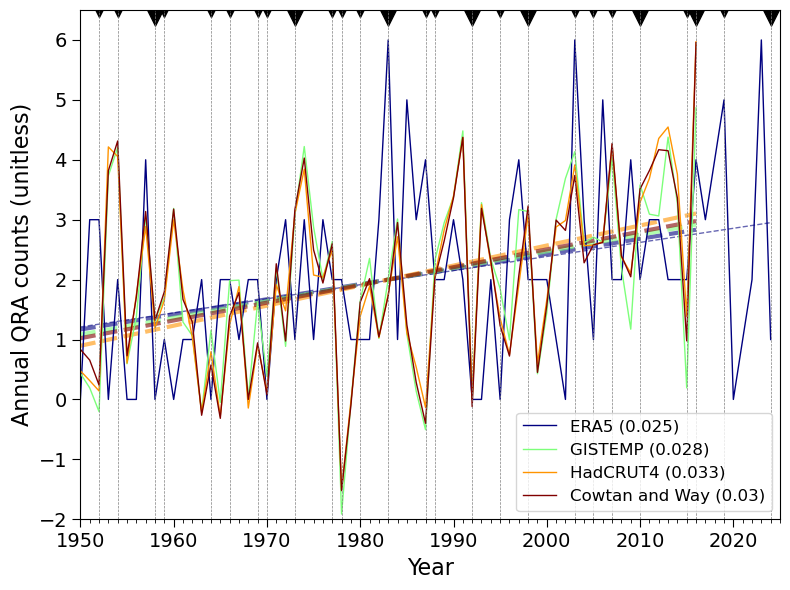

In [7]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)                          

################### ERA5-based QRA count trend line ################### 
ax.plot(yyrange, trend_freq, color=col_freq, linewidth = 3, linestyle='--', alpha=0.6)
ax.plot(ERA5_yyrange, trend_freq_2024, color=col_freq, linewidth = 1, linestyle='--', alpha=0.6)

############# Observation-based QRA fingerprint trend line ############# 
ax.plot(yyrange, trend_GISTEMP_norm, color=col_GISTEMP, linewidth = 3, linestyle='--', alpha=0.6)
ax.plot(yyrange, trend_HadCRUT_norm, color=col_HadCRUT, linewidth = 3, linestyle='--', alpha=0.6)
ax.plot(yyrange, trend_HadCRUT_krig_norm, color=col_HadCRUT_krig, linewidth = 3, linestyle='--', alpha=0.6)

# ERA5-based QRA count series plot
p1 = ax.plot(ERA5_yyrange, freq, color=col_freq, linewidth = 1, label='ERA5 ('+str(round(slope_freq,3))+')')

# Observation-based QRA fingerprint series plot
p2 = ax.plot(yyrange, QRA_GISTEMP2_norm, color=col_GISTEMP, linewidth = 1, label='GISTEMP ('+str(round(slope_GISTEMP_norm,3))+')')
p3 = ax.plot(yyrange, QRA_HadCRUT2_norm, color=col_HadCRUT, linewidth = 1, label='HadCRUT4 ('+str(round(slope_HadCRUT_norm,3))+')')
p4 = ax.plot(yyrange, QRA_HadCRUT_krig2_norm, color=col_HadCRUT_krig, linewidth = 1, label='Cowtan and Way ('+str(round(slope_HadCRUT_krig_norm,3))+')')

# El Nino years
for xa in all_el_nino_years:
    ax.axvline(x=xa, color="gray", linewidth=0.5, linestyle="dashed")
    
for xs in str_el_nino_years:
    ax.scatter(xs, 6.5, color="black", marker="v", s=500)

for xi in el_nino_years:
    ax.scatter(xi, 6.5, color="black", marker="v", s=100)

# Plot settings
ax.tick_params('x',labelsize=labelsize)
ax.tick_params('y',labelsize=labelsize)
ax.tick_params(which='major', length=6) 
ax.tick_params(which='minor', length=3)
minor_locator = AutoMinorLocator(10)
ax.xaxis.set_minor_locator(minor_locator)
ax.set_xlabel('Year',size=size)
ax.set_ylabel('Annual QRA counts (unitless)',size=size)
ax.set_xlim([1950, 2025])
ax.set_ylim(-2, 6.5)

# Plot legend
p = p1+p2+p3+p4
labs = [l.get_label() for l in p]
ax.legend(p, labs, loc="best", frameon=True, fontsize=12)

fig.tight_layout()